# CRISPRi Analysis Pipeline Tutorial

This tutorial provides a comprehensive, yet adaptable framework for analyzing data from CRISPR interference (CRISPRi) screens. The analytical approach described here is inspired by the methodology employed by Rousset et al. (2018), but is intended to be broadly applicable, allowing users to customize each step according to their specific dataset and research objectives.

---
> **Reference to data used:**  
> Rousset, François, Lun Cui, Elise Siouve, Christophe Becavin, Florence Depardieu, and David Bikard. "Genome-wide CRISPR-dCas9 screens in E. coli identify essential genes and phage host factors." PLoS genetics 14, no. 11 (2018): e1007749.

## Installation of Required Packages

Before running the analysis, ensure the necessary Python packages are installed. You can install these directly from your notebook or terminal using the following commands:

```bash
pip install Bio
pip install pydeseq2


In [32]:
# Importing Python libraries
import os
from Bio import SeqIO
from Bio.Seq import Seq
import sys
import gzip
from tqdm import tqdm
import pandas as pd

## Step 1: Data Preparation and Preprocessing

The first step involves transforming your raw sequencing data into structured, analyzable count tables. 

### Typical Workflow:

- **Read Alignment and Counting**  
  - Align sequencing reads to your reference sgRNA library.
  - Generate a count matrix (`sgRNAs × samples`) representing read counts per sgRNA for each condition and replicate.

- **Quality Control Checks**  
  - Confirm adequate sequencing depth.
  - Verify consistency between replicates.

- **Normalization**  
  - Normalize count data to correct for varying sequencing depths across samples (e.g., median-of-ratios normalization is done by DESeq2).
    Resource on normalization: https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html

### Output:

- A count table ready for statistical analysis.

---

In [31]:
#We first open the library file as it was synthesized to obtain the sequence of all guides.
library_handle=open('library.txt','r')
library=SeqIO.parse(library_handle,'fasta')

seqpath = 'fastQfiles' #Folder with (gzipped) fastQ files
files = [f for f in os.listdir(seqpath) if f.endswith('fastq.gz')]

# Create a dictionary to store counts for each guide and sample
targets = {}
for l in library:
    guide_seq = str(l.seq[27:47])  # Extract 20nt guide sequence
    targets[guide_seq] = {}
    for file in files:
        sample = file.split('.fastq')[0]
        targets[guide_seq][sample] = 0


# Process each FASTQ file and count matching guides
for file in tqdm(files, desc="Processing FASTQ files"):
    correct_sequences = 0
    total_reads = 0
    sample = file.split('.fastq')[0]
    with gzip.open(os.path.join(seqpath, file), 'rt', encoding='utf-8') as handle:
        for r in SeqIO.parse(handle, 'fastq'):
            total_reads += 1
            read_seq = str(r.seq[:20])
            if read_seq in targets:
                targets[read_seq][sample] += 1
                correct_sequences += 1
    print(f"{sample}:")
    print(f"{total_reads} reads")
    print(f"{round(100 * correct_sequences / total_reads, 2)}% correct reads")

# Convert to DataFrame and export counts table
counts_table = pd.DataFrame.from_dict(targets, orient='index')
counts_table.to_csv('Counts_table_essentiality.txt', sep='/t')

Processing FASTQ files:   0%|          | 0/4 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Step 2: Exploratory Data Analysis (EDA)

Prior to formal statistical testing, exploratory analyses help you assess data quality and identify potential issues early.

### Suggested analyses:

- **Distribution of Counts**
  - Visualize using histograms or boxplots to identify potential outliers and evaluate distribution consistency.

- **Correlation Analysis**
  - Examine correlations between biological replicates through correlation matrices or scatterplots.

- **Principal Component Analysis (PCA)**
  - Detect sample clustering patterns or batch effects.

### Goal:

- Confirm data integrity and reproducibility before proceeding.

---

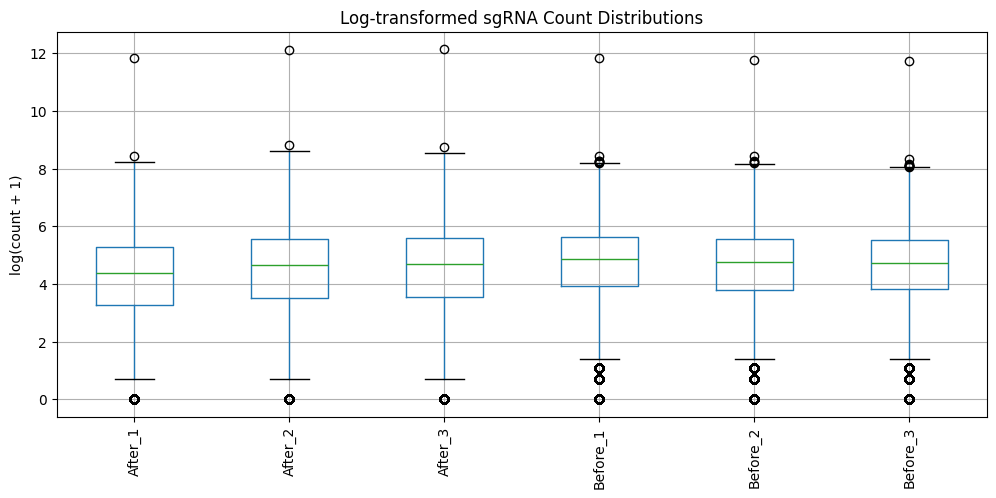

In [33]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load counts table
counts = pd.read_csv("Counts_table_essentiality.txt", sep="\t", index_col=0)

# Log-transform the data (add pseudocount to avoid log(0))
log_counts = np.log1p(counts)

# 1. Plot count distributions per sample
log_counts.boxplot(figsize=(12, 5), rot=90)
plt.title("Log-transformed sgRNA Count Distributions")
plt.ylabel("log(count + 1)")
plt.show()


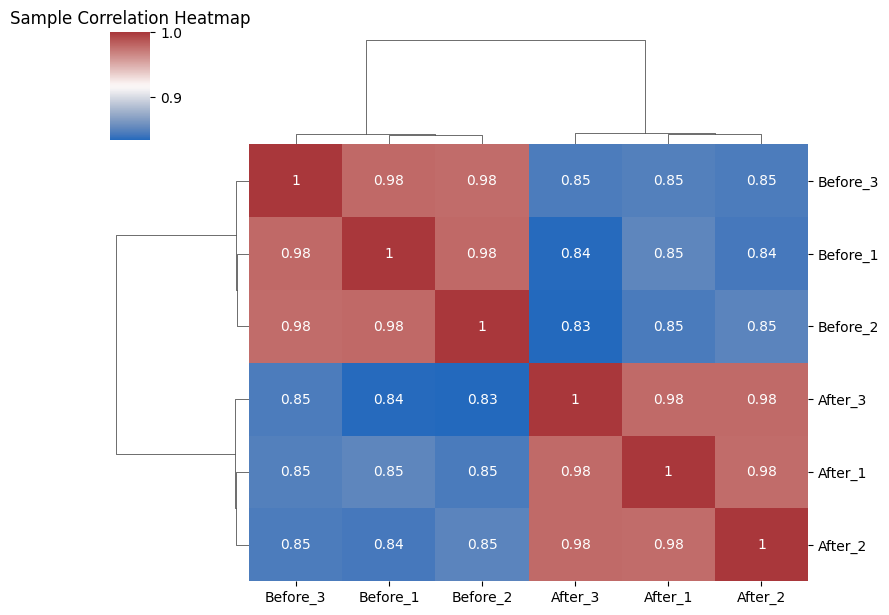

In [34]:

# 2. Correlation heatmap
corr = log_counts.corr()
sns.clustermap(corr, annot=True, cmap="vlag", figsize=(8, 6))
plt.title("Sample Correlation Heatmap")
plt.show()


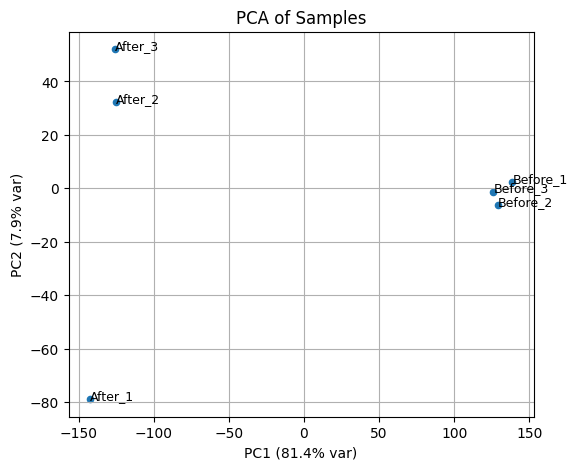

In [35]:
# 3. PCA on log-transformed counts
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_counts.T)

pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"], index=log_counts.columns)
ax = pca_df.plot(kind='scatter', x="PC1", y="PC2", title="PCA of Samples", figsize=(6, 5))

for sample in pca_df.index:
    ax.text(pca_df.loc[sample, "PC1"] + 0.2, pca_df.loc[sample, "PC2"], sample, fontsize=9)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.show()

## Step 3: Statistical Analysis and Identification of Hits

This step identifies significant changes in sgRNA abundance between experimental conditions, typically via differential abundance analysis.

### Recommended Statistical Approaches:

- Use statistical framework **DESeq2** to test differential abundance between conditions.
- Compute key statistical metrics including log₂ fold change, raw p-values, and adjusted p-values (FDR).


In [36]:
import pydeseq2
print(pydeseq2.__version__)

0.5.1


In [37]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [38]:
counts_table = pd.read_csv("Counts_table_essentiality.txt", sep="\t",  index_col=0)
counts_table = counts_table.drop(["After_3", "Before_3"], axis=1)
counts_table 

,After_1,After_2,Before_1,Before_2
AAAAAAAAGCCCCTCGATTG,0,1,1,0
AAAAAAAATGGGCTTTGCGC,3,1,3,0
AAAAAAACCCCGCCGAAGCA,1,1,4,3
AAAAAAACCCGCTGATTAAG,1,0,0,0
AAAAAAACTGCCCCGTGAAC,8,7,11,9
...,...,...,...,...
TTTTTTTCTTGAATATCTAT,4,1,4,5
TTTTTTTGTCTATTACAAAT,9,14,8,4
TTTTTTTTCCTGTTGTCGTT,348,372,295,195
TTTTTTTTCTGCCAACTGCA,16,20,9,8


In [39]:
# Select only numeric columns (e.g., count columns)
numeric_cols = counts_table.select_dtypes(include='number').columns

# Keep rows where at least one value in numeric columns is >= 20
filtered_counts_table = counts_table[(counts_table[numeric_cols] >= 20).any(axis=1)]


In [40]:
filtered_counts_table_transpose = filtered_counts_table.T
filtered_counts_table_transpose

,AAAAAACCTGCTGGTGAGGC,AAAAAACGTATTCGCTTGCA,AAAAAACTGCTGCGTGATAT,AAAAAAGCCTGCTTTCTAGC,AAAAAAGCGCACTTTTTGAC,AAAAAATCTGCCCGTGTCGT,AAAAAATCTGGCGGATATCC,AAAAAATGATGACGCAACGT,AAAAAATGCGTACTGGAACT,AAAAAATGGCGCGCCAGACG,...,TTTTTTTAGCGCAACATTTG,TTTTTTTATCGACCGACCGC,TTTTTTTATGGCTGCCACAG,TTTTTTTATGTCTTGGGGGT,TTTTTTTATTGGCGTGGCTA,TTTTTTTATTTGGTGGTCAT,TTTTTTTCCTCTTAGTACAA,TTTTTTTTCCTGTTGTCGTT,TTTTTTTTCTGCCAACTGCA,TTTTTTTTGAATGGATACTC
After_1,15,46,20,2,29,64,18,31,13,8,...,34,222,105,39,58,62,65,348,16,29
After_2,17,42,14,20,28,78,8,44,8,6,...,34,245,99,33,43,71,72,372,20,30
Before_1,37,46,19,3,35,93,22,43,20,13,...,46,192,78,31,45,57,50,295,9,29
Before_2,44,36,16,7,31,76,11,33,17,21,...,20,155,68,21,17,42,30,195,8,10


In [41]:
#Read metadata
metadata = pd.read_csv("metadata.txt", index_col=0)


In [42]:
metadata

,generation,replicate
After_1,A,1
After_2,A,2
Before_1,B,1
Before_2,B,2


In [43]:
# Design note:
# This example uses a single-factor design (`~generation`) assuming samples were collected
# from the same replicate before and after treatment.
# If you're working with a nested or multifactorial design (e.g., replicate nested in generation),
# you can extend the formula: "~generation + replicate + generation:replicate"
# Including replicate structure increases statistical power by accounting for within-group variation.

# Initialize multithreaded inference backend
inference = DefaultInference(n_cpus=8)

# Create DESeq2 dataset object
dds = DeseqDataSet(
    counts=filtered_counts_table_transpose,  # DataFrame: rows = guides/genes, columns = samples
    metadata=metadata,                       # DataFrame: samples as index, columns = experimental factors
    design="~generation",                    # Model formula: adjust based on your design
    refit_cooks=True,                        # Refit outliers based on Cook's distance
    inference=inference                      # Parallel processing for efficiency
)

In [44]:
#Run actual deseq2 method
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 7.66 seconds.

Fitting dispersion trend curve...
... done in 1.37 seconds.

c:\Users\u0072317\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydeseq2\dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 9.65 seconds.

Fitting LFCs...
... done in 6.13 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [45]:
#dds class object has now been updated to include dispersions, outliers, LFC, ...
print(dds)


AnnData object with n_obs × n_vars = 4 × 82821
    obs: 'generation', 'replicate'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'


In [49]:
dds.layers['normed_counts']

array([[ 18.25022108,  55.96734463,  24.3336281 , ..., 423.40512897,
         19.46690248,  35.28376075],
       [ 15.57005512,  38.46719501,  12.82239834, ..., 340.70944152,
         18.31771191,  27.47656786],
       [ 33.23797048,  41.32288221,  17.068147  , ..., 265.00544028,
          8.08491174,  26.05138226],
       [ 43.56270583,  35.64221386,  15.84098394, ..., 193.06199174,
          7.92049197,   9.90061496]], shape=(4, 82821))

In [50]:
#You can call LFC using: 
print(dds.varm["LFC"])

                      Intercept  generation[T.B]
AAAAAACCTGCTGGTGAGGC   2.823624         0.823172
AAAAAACGTATTCGCTTGCA   3.848262        -0.197118
AAAAAACTGCTGCGTGATAT   2.910643        -0.109577
AAAAAAGCCTGCTTTCTAGC   2.357907        -0.792862
AAAAAAGCGCACTTTTTGAC   3.410331         0.025948
...                         ...              ...
TTTTTTTATTTGGTGGTCAT   4.249316        -0.410684
TTTTTTTCCTCTTAGTACAA   4.281105        -0.658791
TTTTTTTTCCTGTTGTCGTT   5.943053        -0.507470
TTTTTTTTCTGCCAACTGCA   2.937812        -0.857848
TTTTTTTTGAATGGATACTC   3.442664        -0.547609

[82821 rows x 2 columns]



Now we will perform statistical tests to calculate p-values

In [51]:
from pydeseq2.ds import DeseqStats

ds = DeseqStats(
    dds, 
    contrast=["generation", "A", "B"],  # Compare A vs B
    inference=inference                # Use same inference backend
)

### Interpretation of Statistical Output:

| Column           | Description                                                                                       |
|------------------|---------------------------------------------------------------------------------------------------|
| `baseMean`       | Mean normalized count for the gene/sgRNA across all samples (not transformed).                    |
| `log2FoldChange` | The log₂ fold change between the two groups you're comparing (e.g. A vs B).                       |
| `lfcSE`          | Standard error of the log₂ fold change. Reflects variability/uncertainty of the estimate.         |
| `stat`           | The Wald test statistic: `log2FoldChange / lfcSE`.                                                |
| `pvalue`         | The raw (unadjusted) p-value from the Wald test.                                                  |
| `padj`           | The adjusted p-value (FDR), typically using Benjamini-Hochberg correction.                        |


In [52]:
#Perfrom Wald test
ds.summary()
ds.results_df.to_csv("wald_test_results.csv", index=False)

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: generation A vs B
                        baseMean  log2FoldChange     lfcSE      stat  \
AAAAAACCTGCTGGTGAGGC   27.655238       -1.187586  0.550842 -2.155948   
AAAAAACGTATTCGCTTGCA   42.849909        0.284381  0.438924  0.647904   
AAAAAACTGCTGCGTGATAT   17.516289        0.158087  0.683637  0.231244   
AAAAAAGCCTGCTTTCTAGC    7.594119        1.143858  1.147643  0.996702   
AAAAAAGCGCACTTTTTGAC   30.765447       -0.037436  0.508349 -0.073642   
...                          ...             ...       ...       ...   
TTTTTTTATTTGGTGGTCAT   58.312287        0.592492  0.373061  1.588191   
TTTTTTTCCTCTTAGTACAA   54.911519        0.950434  0.397050  2.393737   
TTTTTTTTCCTGTTGTCGTT  305.545501        0.732124  0.191612  3.820867   
TTTTTTTTCTGCCAACTGCA   13.447505        1.237613  0.774011  1.598961   
TTTTTTTTGAATGGATACTC   24.678081        0.790033  0.611493  1.291974   

                        pvalue      padj  
AAAAAACCTGCTGGTGAGGC  0.031088  0.14

## Step 4: Aggregating sgRNA-level results to gene-level using robust rank aggregation (RRA)

Robust Rank Aggregation (RRA) is a statistical method designed to identify items (e.g., genes) that consistently appear at the top of ranked lists more often than expected by chance. In the context of CRISPR/Cas9 screens, RRA is used to combine multiple sgRNA-level results targeting the same gene into a gene-level score.

This method is commonly used in tools like **MAGeCK** to:

- Aggregate multiple sgRNAs per gene
- Prioritize genes whose sgRNAs show consistently strong effects (e.g., low p-values)

### How RRA works

- Each sgRNA is assigned a p-value from a differential analysis (e.g., DESeq2).
- The p-values are ranked per gene, and RRA evaluates whether the ranks are lower (better) than expected by chance.
- This is done using the **cumulative distribution function (CDF) of the Beta distribution**.
- If the ranks are consistent with random noise, the resulting RRA p-value is high; if they are unusually low, the RRA p-value is small.

RRA is performed **separately** for:
- **Enriched sgRNAs** (log₂ fold change > 0)
- **Depleted sgRNAs** (log₂ fold change < 0)

---

### Complementary Wald test on gene-level mean FC

In addition to RRA, we calculate a **Wald test** on the **mean log₂ fold change** of the significant sgRNAs per gene (again, separately for enriched and depleted).

This tests the null hypothesis:
> H₀: mean log₂FC = 0


---


### High-Confidence Hits

Genes that pass **both** RRA and Wald FDR thresholds (e.g., FDR < 0.05) are considered **high-confidence hits**, reflecting both **consistent** and **statistically strong** effects across sgRNAs.


In [53]:
import numpy as np
import pandas as pd
from scipy.stats import beta, norm
from statsmodels.stats.multitest import multipletests

def alpha_beta(p_vals):
    """RRA-like aggregation of p-values."""
    p_vals = np.sort(p_vals)
    n = len(p_vals)
    return min([beta.cdf(p_vals[i], 1, n - i) for i in range(n)])

def analyze_direction(df, direction="positive"):
    """Performs RRA + Wald test per gene in a given direction."""
    if direction == "positive":
        subset = df[(df["log2FoldChange"] > 0) & (df["padj"] < 0.05)]
    elif direction == "negative":
        subset = df[(df["log2FoldChange"] < 0) & (df["padj"] < 0.05)]
    else:
        raise ValueError("Direction must be 'positive' or 'negative'")

    rra_records = []
    wald_records = []

    for gene, group in subset.groupby("gene"):
        pvals = group["padj"].dropna().values
        lfcs = group["log2FoldChange"].values
        n = len(pvals)

        if n < 2:
            continue

        # RRA
        rra_p = alpha_beta(pvals)

        # Wald
        mean_lfc = np.mean(lfcs) #you could also change this to median
        sem = np.std(lfcs, ddof=1) / np.sqrt(n)
        z = mean_lfc / sem
        pval = 2 * norm.sf(abs(z))

        rra_records.append((gene, rra_p, n, mean_lfc))
        wald_records.append((gene, mean_lfc, sem, z, pval, n))

    rra_df = pd.DataFrame(rra_records, columns=[
        "gene",
        f"gene_pval_{direction}",
        f"ngrna_lfc_{direction}",
        f"gene_lfc_{direction}"
    ])
    rra_df[f"fdr_gene_{direction}_rra"] = multipletests(rra_df[f"gene_pval_{direction}"], method="fdr_bh")[1]

    wald_df = pd.DataFrame(wald_records, columns=[
        "gene",
        f"mean_log2FC_{direction}",
        f"SEM_{direction}",
        f"z_{direction}",
        f"pval_gene_{direction}",
        f"ngrna_tested_{direction}"
    ])
    wald_df[f"fdr_gene_{direction}_wald"] = multipletests(wald_df[f"pval_gene_{direction}"], method="fdr_bh")[1]

    return rra_df, wald_df

def gene_level_analysis_rra_wald(sgrna_df):
    """Run full RRA + Wald analysis for both positive and negative directions."""
    pos_rra, pos_wald = analyze_direction(sgrna_df, "positive")
    neg_rra, neg_wald = analyze_direction(sgrna_df, "negative")

    result = pos_rra.merge(pos_wald, on="gene", how="outer")
    result = result.merge(neg_rra, on="gene", how="outer")
    result = result.merge(neg_wald, on="gene", how="outer")

    return result


In [117]:
deseq = ds.results_df
deseq.index.name = "sgRNA"



In [118]:
deseq

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
sgRNA,,,,,,
AAAAAAACTGCCCCGTGAAC,8.728499,-0.230353,0.940269,-0.244987,0.806467,0.950194
AAAAAAAGATGATACGTCAG,7.730921,0.785528,1.006247,0.780652,0.435007,0.771666
AAAAAAAGCCAGCACCCGGC,9.225865,0.380735,0.936490,0.406555,0.684335,0.908596
AAAAAAAGCGATTTAACCGT,8.017691,-0.510335,1.009917,-0.505324,0.613331,0.878264
AAAAAAATCATCCATCCGGC,6.036580,-5.960336,2.598574,-2.293694,0.021808,0.111584
...,...,...,...,...,...,...
TTTTTTTCCTCTTAGTACAA,54.893616,0.952851,0.396263,2.404592,0.016191,0.088348
TTTTTTTGTCTATTACAAAT,8.727885,1.091776,0.960357,1.136843,0.255604,0.600257
TTTTTTTTCCTGTTGTCGTT,305.428475,0.734523,0.191517,3.835299,0.000125,0.001350


In [119]:
mapping = pd.read_csv("library_sgRNA_gene_map.txt", sep=" ")  # use correct separator if it's tab
mapping = mapping[["target", "gene"]].dropna()
mapping = mapping.rename(columns={"target": "sgRNA"})

In [120]:
deseq_with_genes = deseq.reset_index().merge(mapping, on="sgRNA", how="inner")

In [121]:
deseq_with_genes

,sgRNA,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
0,AAAAAAACTGCCCCGTGAAC,8.728499,-0.230353,0.940269,-0.244987,0.806467,0.950194,ydjG
1,AAAAAAAGATGATACGTCAG,7.730921,0.785528,1.006247,0.780652,0.435007,0.771666,bioC
2,AAAAAAAGCCAGCACCCGGC,9.225865,0.380735,0.936490,0.406555,0.684335,0.908596,ryhB
3,AAAAAAAGCGATTTAACCGT,8.017691,-0.510335,1.009917,-0.505324,0.613331,0.878264,acnA
4,AAAAAACGGCGCTTTTATTC,6.017855,0.046598,2.287315,0.020372,0.983747,0.996366,ssuA
...,...,...,...,...,...,...,...,...
85859,TTTTTTTATTGGCGTGGCTA,41.782145,0.926711,0.505112,1.834666,0.066555,0.256874,yjfL
85860,TTTTTTTATTTGGTGGTCAT,58.289332,0.594883,0.372357,1.597614,0.110129,0.363422,yicL
85861,TTTTTTTCCTCTTAGTACAA,54.893616,0.952851,0.396263,2.404592,0.016191,0.088348,ubiC
85862,TTTTTTTTCCTGTTGTCGTT,305.428475,0.734523,0.191517,3.835299,0.000125,0.001350,cadC


In [122]:
#gene_results = compute_gene_level_results(deseq_with_genes)
#gene_results.to_csv("gene_level_rra_results.tsv", sep="\t", index=False)

gene_rra_wald = gene_level_analysis_rra_wald(deseq_with_genes)
gene_rra_wald.to_csv("gene_level_rra_wald_results.tsv", sep="\t", index=False)

In [123]:
gene_rra_wald

,gene,gene_pval_positive,ngrna_lfc_positive,gene_lfc_positive,fdr_gene_positive_rra,mean_log2FC_positive,SEM_positive,z_positive,pval_gene_positive,ngrna_tested_positive,...,gene_pval_negative,ngrna_lfc_negative,gene_lfc_negative,fdr_gene_negative_rra,mean_log2FC_negative,SEM_negative,z_negative,pval_gene_negative,ngrna_tested_negative,fdr_gene_negative_wald
0,C0343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.657374e-05,2.0,-1.714176,8.036306e-05,-1.714176,0.666994,-2.570003,0.010170,2.0,0.014667
1,C0362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.338644e-173,8.0,-2.672479,2.853746e-171,-2.672479,0.568197,-4.703439,0.000003,8.0,0.000006
2,C0664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.829166e-124,3.0,-3.714517,1.963815e-122,-3.714517,0.905137,-4.103819,0.000041,3.0,0.000089
3,G0-10700,0.000098,2.0,0.567030,0.000342,0.567030,0.010456,54.231639,0.000000e+00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aaeB,0.000018,2.0,0.376804,0.000084,0.376804,0.017678,21.314690,8.295417e-101,2.0,...,2.913807e-03,4.0,-1.594678,3.137542e-03,-1.594678,0.649179,-2.456453,0.014032,4.0,0.019489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,zntA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.873379e-11,2.0,-2.230114,6.425799e-11,-2.230114,0.765636,-2.912762,0.003582,2.0,0.005651
2128,znuB,0.000024,4.0,0.532461,0.000108,0.532461,0.079668,6.683542,2.332342e-11,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,zraS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.868120e-02,2.0,-1.050105,4.868120e-02,-1.050105,0.731202,-1.436135,0.150964,2.0,0.160059
2130,zupT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.274737e-02,2.0,-0.792316,2.319973e-02,-0.792316,0.216619,-3.657649,0.000255,2.0,0.000494


In [124]:
gene_results

,gene,gene_pval_positive,ngrna_lfc_positive,fdr_gene_positive,gene_lfc_positive,gene_pval_negative,ngrna_lfc_negative,fdr_gene_negative,gene_lfc_negative
0,C0343,NaN,NaN,NaN,NaN,1.331431e-04,4.0,2.822718e-04,-1.714176
1,C0362,0.516594,4.0,0.912923,NaN,3.338644e-173,8.0,6.316397e-171,-2.672479
2,C0465,0.127833,2.0,0.350867,NaN,NaN,NaN,NaN,NaN
3,C0664,NaN,NaN,NaN,NaN,6.381944e-124,5.0,7.244418e-122,-3.714517
4,G0-10697,0.978761,2.0,0.999463,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4238,zraR,0.519713,18.0,0.915775,0.541198,1.885361e-44,13.0,2.134057e-43,-5.036901
4239,zraS,0.043671,15.0,0.169398,0.473474,3.548769e-01,14.0,4.838456e-01,-1.050105
4240,zupT,0.919378,8.0,0.999463,NaN,2.090440e-01,15.0,3.001561e-01,-0.792316
4241,zur,NaN,NaN,NaN,0.447155,3.554534e-02,3.0,5.773574e-02,-1.453244


| Column               | Meaning                                                                 |
|----------------------|-------------------------------------------------------------------------|
| `gene`               | The gene targeted by one or more sgRNAs.                                |
| `gene_pval_positive` | RRA p-value for upregulated guides (log2FC > 0).                        |
| `ngrna_lfc_positive` | Number of significant sgRNAs (padj < 0.05 and log2FC > 0).              |
| `fdr_gene_positive`  | Adjusted p-value (FDR) for positive-direction RRA p-value.              |
| `gene_lfc_positive`  | Mean log2FC for significant upregulated guides (optional).              |
| `gene_pval_negative` | RRA p-value for downregulated guides (log2FC < 0).                      |
| `ngrna_lfc_negative` | Number of significant downregulated sgRNAs.                             |
| `fdr_gene_negative`  | FDR-adjusted gene p-value for negative direction.                       |
| `gene_lfc_negative`  | Mean log2FC for significant downregulated guides.    

Now lets extract gene list from it

In [54]:
# Set thresholds
fdr_cutoff = 0.05
lfc_threshold = 1.0  # optional

# High-confidence DEPLETED genes
high_conf_depleted = gene_rra_wald[
    (gene_rra_wald["fdr_gene_negative_rra"] < fdr_cutoff) &
    (gene_rra_wald["fdr_gene_negative_wald"] < fdr_cutoff) &
    (gene_rra_wald["gene_lfc_negative"] < -lfc_threshold)
]

# High-confidence ENRICHED genes
high_conf_enriched = gene_rra_wald[
    (gene_rra_wald["fdr_gene_positive_rra"] < fdr_cutoff) &
    (gene_rra_wald["fdr_gene_positive_wald"] < fdr_cutoff) &
    (gene_rra_wald["gene_lfc_positive"] > lfc_threshold)
]

# Save results
high_conf_depleted.to_csv("high_conf_depleted.tsv", sep="\t", index=False)
high_conf_enriched.to_csv("high_conf_enriched.tsv", sep="\t", index=False)


NameError: name 'gene_rra_wald' is not defined

In [132]:
high_conf_depleted

,gene,gene_pval_positive,ngrna_lfc_positive,gene_lfc_positive,fdr_gene_positive_rra,mean_log2FC_positive,SEM_positive,z_positive,pval_gene_positive,ngrna_tested_positive,...,gene_pval_negative,ngrna_lfc_negative,gene_lfc_negative,fdr_gene_negative_rra,mean_log2FC_negative,SEM_negative,z_negative,pval_gene_negative,ngrna_tested_negative,fdr_gene_negative_wald
0,C0343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.657374e-05,2.0,-1.714176,8.036306e-05,-1.714176,0.666994,-2.570003,1.016976e-02,2.0,1.466694e-02
1,C0362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.338644e-173,8.0,-2.672479,2.853746e-171,-2.672479,0.568197,-4.703439,2.558157e-06,8.0,6.386497e-06
2,C0664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.829166e-124,3.0,-3.714517,1.963815e-122,-3.714517,0.905137,-4.103819,4.063854e-05,3.0,8.857495e-05
4,aaeB,0.000018,2.0,0.376804,0.000084,0.376804,0.017678,21.314690,8.295417e-101,2.0,...,2.913807e-03,4.0,-1.594678,3.137542e-03,-1.594678,0.649179,-2.456453,1.403160e-02,4.0,1.948922e-02
5,aas,0.004712,3.0,0.553574,0.007556,0.553574,0.091045,6.080231,1.200094e-09,3.0,...,3.680183e-17,3.0,-2.272667,7.968551e-17,-2.272667,0.557887,-4.073703,4.627155e-05,3.0,9.970879e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,zapD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.910551e-20,2.0,-3.672341,7.176428e-20,-3.672341,1.372857,-2.674963,7.473752e-03,2.0,1.108709e-02
2125,zipA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.230703e-116,6.0,-7.058586,1.998451e-114,-7.058586,0.681763,-10.353425,4.037765e-25,6.0,3.339994e-24
2127,zntA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.873379e-11,2.0,-2.230114,6.425799e-11,-2.230114,0.765636,-2.912762,3.582472e-03,2.0,5.650735e-03
2130,zupT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.274737e-02,2.0,-0.792316,2.319973e-02,-0.792316,0.216619,-3.657649,2.545390e-04,2.0,4.939432e-04


In [133]:
high_conf_enriched

,gene,gene_pval_positive,ngrna_lfc_positive,gene_lfc_positive,fdr_gene_positive_rra,mean_log2FC_positive,SEM_positive,z_positive,pval_gene_positive,ngrna_tested_positive,...,gene_pval_negative,ngrna_lfc_negative,gene_lfc_negative,fdr_gene_negative_rra,mean_log2FC_negative,SEM_negative,z_negative,pval_gene_negative,ngrna_tested_negative,fdr_gene_negative_wald
3,G0-10700,0.000098,2.0,0.567030,0.000342,0.567030,0.010456,54.231639,0.000000e+00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aaeB,0.000018,2.0,0.376804,0.000084,0.376804,0.017678,21.314690,8.295417e-101,2.0,...,2.913807e-03,4.0,-1.594678,3.137542e-03,-1.594678,0.649179,-2.456453,0.014032,4.0,0.019489
5,aas,0.004712,3.0,0.553574,0.007556,0.553574,0.091045,6.080231,1.200094e-09,3.0,...,3.680183e-17,3.0,-2.272667,7.968551e-17,-2.272667,0.557887,-4.073703,0.000046,3.0,0.000100
7,abgB,0.000246,4.0,0.414059,0.000730,0.414059,0.037893,10.927067,8.556945e-28,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,abgR,0.000187,3.0,0.463375,0.000581,0.463375,0.075626,6.127192,8.944366e-10,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,ytfF,0.014257,2.0,0.692806,0.017683,0.692806,0.137790,5.027995,4.956343e-07,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2121,ytfR,0.008126,3.0,0.446332,0.011573,0.446332,0.047924,9.313245,1.239849e-20,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2123,ytjA,0.000153,3.0,0.602383,0.000496,0.602383,0.078239,7.699231,1.368877e-14,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,zitB,0.000977,4.0,0.486660,0.002196,0.486660,0.073485,6.622586,3.529694e-11,4.0,...,2.739244e-12,2.0,-0.772793,4.783019e-12,-0.772793,0.406889,-1.899271,0.057529,2.0,0.068296


## Step 5: Biological Interpretation and Validation

Once significant guides or genes have been identified, the final step is to interpret the results in light of your biological system and experimental context.

This step is critical: statistical significance does not automatically imply biological relevance. The goal is to translate differential sgRNA abundance into meaningful biological insights.

---

### Considerations for Interpretation:

- **Thresholds for Hit Calling**
  - Use an adjusted p-value threshold (e.g., FDR < 0.05) to control for false discoveries.
  - Apply a fold-change threshold (e.g., log₂ fold change ≥ 1 or ≤ -1) to ensure biological impact.

- **Assessing Biological Relevance**
  - Map significant genes to known biological functions, pathways, or phenotypes.
  - Use gene set enrichment tools to identify overrepresented processes (e.g., GO terms, KEGG pathways).
  - Explore literature and databases (e.g., EcoCyc, STRING, BioGRID) for gene roles and interactions.
  - Visualize results using volcano plots, pathway diagrams, or gene interaction networks.

- **Advanced Analyses** (Potentially another code club?, dealing with hit lists)
  - **Pathway enrichment**: Highlight affected biological processes.
  - **Network analysis**: Identify clusters or hubs of functionally related genes.
  - **Integration with other omics data**: Strengthen confidence in candidate hits.

---

